___
# Ciência dos Dados - PROJETO 3

___
### *Bruno Kaczelnik, Guilherme Lotaif, Renato Tajima, Thiago Verardo*
___

# Análise de Airbnb nas maiores cidades americanas

___

## 1. Introdução

   Neste Projeto será feita uma análise dos dados que possuimos de Airbnb nos Estados Unidos, e a partir dos dados que julgarmos pertinentes ao nosso estudo. Serão usados diferentes **métodos de predição** para descobrir`o preço de um aluguel dependendo das características fornecidas`, após usarmos os diferentes métodos, vamos comparar os resultados de cada método, finalmente poderemos concluir o projeto..

   Um pouco mais sobre a plataforma digital Airbnb: Ela é utilizada para efetuar o aluguel de uma casa ou apartamento de outros usuários da própria plataforma. Com anúncios em 192 países, podemos concluir que é uma plataforma é bem grande, somente nos Estados Unidos existem aproximadamente 600.000 possiveis locais para aluguel. Com tantas opções, a escolha que o usuário faz quanto ao local é feita baseada nas **informações fornecidas pelo propretario**, tais informações podem variar desde quantos banheiros a residência possui, até se ela possui acesso a uma rede Wifi.

**Fonte do dataset:** www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml

___
## 2. Minerando dados e características do dataset

O dataset que vamos utilizar nesse projeto possui diversas colunas com informações dos Airbnb nos Estados Unidos, portannto temos que percorrer todas essas colunas para fazer uma limpeza, e deixar somente as informações que serão pertinentes a nossa análise.

**Importando as bibliotecas que serão utilizadas:**

In [26]:
#Importando bibliotecas:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
from scipy.stats import norm,probplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

plt.style.use('ggplot')

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
/Users/guilherme/Downloads/Projeto-3-CDD---DPA-master


In [3]:
warnings.filterwarnings("ignore")

### - Base de dados

In [4]:
#Importado o arquivo de treinamento:
df = pd.read_csv('train.csv')

In [5]:
#Análisando o tamanho do dataframe de treino:
linhas, colunas = df.shape
print("O Dataframe possui {0} linhas por {1} colunas.".format(linhas, colunas))

O Dataframe possui 74111 linhas por 29 colunas.


...

#### Limpando o dataframe de treino para ser análisado:
Esta etapa consiste em uma preparação do dataframe para facilitar a análise no mesmo, assim evitando ocorrências de complicações ou erros que atrapalhem futuramento os nosssos classificadores. Portanto iremos limpar os titulos de cada coluna, vamos remover os valores nulos de cada categoria, assim como colunas desnecessárias.

In [6]:
#Removendo os espaços em branco dos nomes das colunas:
df.columns = [espaços.strip() for espaços in df.columns.tolist()]

In [7]:
df["log_price"] = df["log_price"].astype("float64")
#df["log_price"] = df["log_price"].astype("float64")
#df["log_price"] = df["log_price"].astype("float64")
#df["log_price"] = df["log_price"].astype("float64")

In [59]:
#Transformando as datas do dataframe para o formato correto:
df["host_since"] = pd.to_datetime(df["host_since"], errors='coerce')
df["last_review"] = pd.to_datetime(df["last_review"], errors='coerce')
df["first_review"] = pd.to_datetime(df["first_review"], errors='coerce')

In [9]:
#Convertendo string de porcentagem para float:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')

In [10]:
#Removendo colunas que não sao pertinentes ao estudo:
df = df.drop(["latitude","longitude","name","thumbnail_url","id","description","amenities","zipcode"],axis=1);

In [11]:
#Apagando valores nulos que podem causar problemas posteriores:
df = df.dropna(axis=0, subset=['bathrooms','first_review','host_has_profile_pic','host_identity_verified',
                               'host_response_rate','host_since','last_review','neighbourhood','review_scores_rating',
                               'bedrooms','beds'])

In [12]:
#Corrigindo simplificação no arquivo:
df.loc[(df["instant_bookable"] == "f"),"instant_bookable"] = "False"
df.loc[(df["instant_bookable"] == "t"),"instant_bookable"] = "True"

df.loc[(df["host_has_profile_pic"] == "f"),"host_has_profile_pic"] = "False"
df.loc[(df["host_has_profile_pic"] == "t"),"host_has_profile_pic"] = "True"

df.loc[(df["host_identity_verified"] == "f"),"host_identity_verified"] = "False"
df.loc[(df["host_identity_verified"] == "t"),"host_identity_verified"] = "True"

In [13]:
df.head(2)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,...,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,2017-08-05,...,False,100.0,2017-06-19,True,2017-09-23,Hell's Kitchen,6,93.0,3.0,3.0
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,2017-04-30,...,True,100.0,2016-10-25,True,2017-09-14,Harlem,10,92.0,1.0,3.0


...


#### Transformando categorias qualiativas em quantiativas:

O método usado para efetuar essa conversão é chamado de **One Hot Encoding**, que transforma variaveis categóricas em vetores binarios. Tal método transforma todas as variaveis em 0 menos a do item analisado, desse modo permitindo que sejam feitam análises em cima desse dados.
<br>
<br>

In [14]:
#Função para chamar o get_dummies e remover a coluna base:
def dummify(data, column_name):
    df1 = data.copy()
    df2 = pd.concat([df1.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

#Transformando "category" em uma variável quantitativa:
DF = dummify(df, "property_type")
DF = dummify(DF, "room_type")
DF = dummify(DF, "bed_type")
DF = dummify(DF, "cancellation_policy")
DF = dummify(DF, "cleaning_fee")
DF = dummify(DF, "city")
DF = dummify(DF, "host_has_profile_pic")
DF = dummify(DF, "host_identity_verified")
DF = dummify(DF, "instant_bookable")
DF = dummify(DF, "neighbourhood") #Talvez tenha pouca influência

<br>

### - Análise descritiva

Após realizarmos o filtro, deve-se realizar uma análise exploratória dos dados, com o  objetivo de achar as váriaveis que mais influenciam no nosso objetivo e que assim possam nos ajudar a prever qual será a avaliação de um hotel aleatório. Ela será feita com o auxílio do pandas_profiling e seaborn.


#### Será que o tipo do quarto altera o seu valor?

In [81]:
Tipo = df.room_type.value_counts()

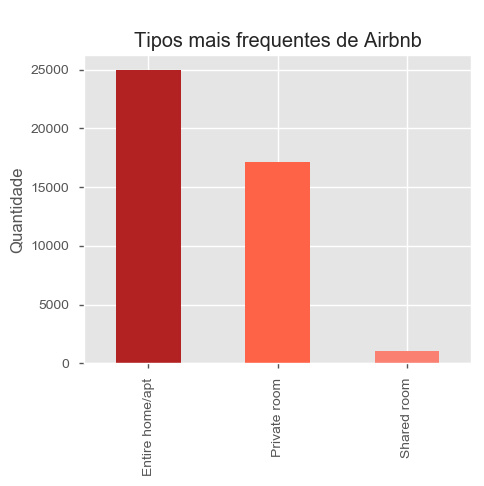

In [93]:
#Criando uma tabela com os dados:
plot = Tipo.plot(kind='bar',figsize=(5, 4), color = ["firebrick","tomato","salmon"])
ax = plt.subplot(111)
plt.title("\nTipos mais frequentes de Airbnb")
plt.ylabel('Quantidade')
plt.show()

In [132]:
entire,private,shared = [],[],[]
for tipo,preco in zip(df['room_type'],df['log_price']):
    if tipo == "Entire home/apt":
        entire.append(preco)
    elif tipo == "Private room":
        private.append(preco)
    elif tipo == "Shared room":
        shared.append(preco)

In [139]:
print(" Entire room:  {:.2f}\n".format(np.mean(entire)),
      "Private room: {:.2f}\n".format(np.mean(private)),
      "Shared room:  {:.2f}\n".format(np.mean(shared)))

 Entire room:  5.14
 Private room: 4.30
 Shared room:  3.78



In [15]:
#utilizandoo o pandas_profiling
#df é o dataframe após o filtro
pandas_profiling.ProfileReport(df)

Number of variables,22
Number of observations,43091
Total Missing (%),0.0%
Total size in memory,6.9 MiB
Average record size in memory,169.0 B
Numeric,9
Categorical,10
Boolean,1
Date,2
Text (Unique),0
Rejected,0


___
## 3. Modelos de predição

Adequando nosso dataframe para as predições:

In [57]:
df_pred = DF.drop(["log_price"],axis=1)

In [17]:
#Estabelecendo variave random_seed:
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)

In [18]:
#Dividindo os dados do dataframe em teste e treino:
X_train, X_test, y_train, y_test = train_test_split(df_pred, DF.log_price, test_size = 0.33, random_state = RANDOM_SEED)

...<br>
<br>

o `MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa)`

In [19]:
X = np.mean(DF.log_price)
X

4.772880520973572

...<br>
<br>

o `MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)`

In [35]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.neighbors import KNeighborsRegressor

In [60]:
#Chamando o classificador:
knn = KNeighborsRegressor(n_neighbors=3)

#Fazendo um fit nos dados de treino:
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

#Descobrindo a acurácia do modelo de predição:
print('R2 é de: {:.2f}'.format(r2_score(y_test, knn_pred)))

R2 é de: 0.44


...<br>
<br>

o `MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)`

In [37]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.linear_model import LinearRegression

In [61]:
#Chamando o classificador:
linear = LinearRegression()

#Fazendo um fit nos dados de treino:
linear.fit(X_train, y_train)

linear_pred = linear.predict(X_test)

#Descobrindo a acurácia do modelo de predição:
print('R2 é de: {:.2f}'.format(r2_score(y_test, linear_pred)))

R2 é de: -746845918954922.88


...<br>
<br>

o `MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)`

In [43]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.tree import DecisionTreeRegressor

In [62]:
#Chamando o classificador:
tree = DecisionTreeRegressor()

#Fazendo um fit nos dados de treino:
tree.fit(X_train, y_train)   

tree_pred = clf.predict(X_test)

#Descobrindo a acurácia do modelo de predição:
print("R2 é de: {:.2f}".format(r2_score(y_test, tree_pred)))

R2 é de: 0.63


...<br>
<br>

o `MODELO RANDOM FOREST (Para comparação`

In [31]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.ensemble import RandomForestRegressor

In [63]:
#Chamando o RandomForestClassifier:
model = RandomForestRegressor()

#Fazendo um fit nos dados de treino:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#Descobrindo a acurácia do modelo de predição:
print('R2 é de: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 é de: 0.69


___
## 4. Processo e estatísticas de validação

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## 5. Conclusão

___
## 6. Referências bibliográficas

https://www.mldata.io/tutorials/scikit_knn/

https://www.kaggle.com/pratsiuk/valueerror-unknown-label-type-continuous